# GAN Debugging Notebook

This notebook is provided to help you debug your code. We provide you with small discriminator and generator networks that you can train on the MNIST dataset. This small GAN can be trained quickly on MNIST and will help you verify that your loss functions and training code is correct.

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
from gan.train import train
from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img
from gan.losses import discriminator_loss, generator_loss, ls_discriminator_loss, ls_generator_loss

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## MNIST Dataset


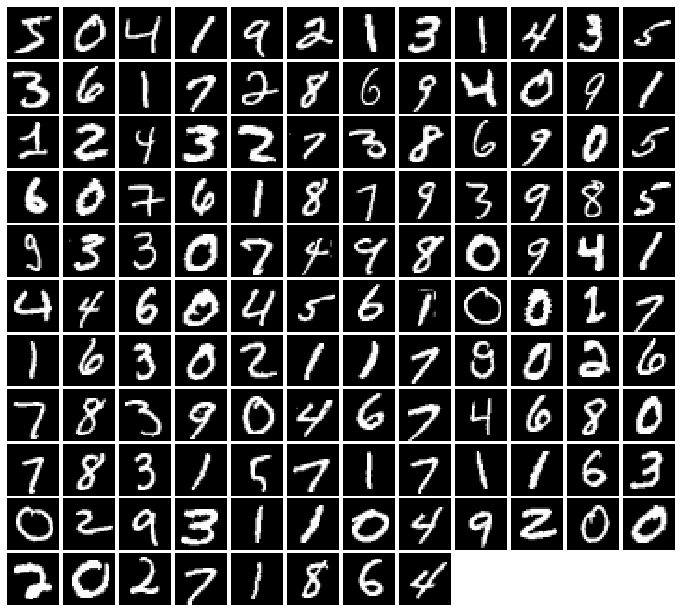

In [4]:
NOISE_DIM = 100
batch_size = 128

mnist = datasets.MNIST('./MNIST_data', train=True, download=True,
                           transform=transforms.ToTensor())
loader_train = DataLoader(mnist, batch_size=batch_size, drop_last=True)


imgs = loader_train.__iter__().next()[0].view(batch_size, 784).numpy().squeeze()
show_images(imgs)

# Discriminator and Generator


In [5]:
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size() # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image


In [6]:
def discriminator():
    """
    Initialize and return a simple discriminator model.
    """
    model = torch.nn.Sequential( Flatten(),
                                torch.nn.Linear(784, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 256), 
                                torch.nn.LeakyReLU(),
                                torch.nn.Linear(256, 1)
    )
    return model

In [7]:
def generator(noise_dim=NOISE_DIM):
    """
    Initialize and return a simple generator model.
    """
    
    model = nn.Sequential(
        torch.nn.Linear(noise_dim, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 1024),
        torch.nn.ReLU(),
        torch.nn.Linear(1024, 784),
        torch.nn.Tanh()
    )

    return model

Test to make sure the number of parameters in the generator is correct:

# Train

The simple model provided will train on MNIST in only a few minutes. You should expect results that resemble the following if your loss function and training loop implementations are correct:

<img src="gan_samples/mnist.jpg" width=500>

### GAN loss

**TODO:** Implement the `discriminator_loss` and `generator_loss` functions in `gan/losses.py`.

The generator loss is given by:
$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
and the discriminator loss is:
$$ \ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
Note that these are negated from the equations presented earlier as we will be *minimizing* these losses.

**HINTS**: You should use the `torch.nn.functional.binary_cross_entropy_with_logits` function to compute the binary cross entropy loss since it is more numerically stable than using a softmax followed by BCE loss. The BCE loss is needed to compute the log probability of the true label given the logits output from the discriminator. Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross entropy loss is

$$ bce(s, y) = -y * \log(s) - (1 - y) * \log(1 - s) $$


Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the minibatch, so make sure to combine the loss by averaging instead of summing.

In [8]:
import torch
from torch.nn.functional import binary_cross_entropy_with_logits as bce_loss
from torch.nn import MSELoss

def discriminator_loss(logits_real, logits_fake):
    """
    Computes the discriminator loss.
    
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits 
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.
    
    Inputs:
    - logits_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing (scalar) the loss for the discriminator.
    """
    
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    label_real = torch.full((logits_real.shape[0],), 1, dtype=torch.float)
    label_fake = torch.full((logits_fake.shape[0],), 0, dtype=torch.float)
    loss_real = bce_loss(logits_real,label_real,reduction="mean")
    loss_fake = bce_loss(logits_fake,label_fake,reduction="mean")
#     print(loss_real)
#     print(loss_fake)
    loss = (loss_real * logits_real.shape[0] + loss_fake * logits_fake.shape[0])/(logits_real.shape[0] + logits_fake.shape[0])
    ##########       END      ##########
    
    return loss

def generator_loss(logits_fake):
    """
    Computes the generator loss.
    
    You should use the stable torch.nn.functional.binary_cross_entropy_with_logits 
    loss rather than using a separate softmax function followed by the binary cross
    entropy loss.

    Inputs:
    - logits_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Returns:
    - loss: PyTorch Tensor containing the (scalar) loss for the generator.
    """
    
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    # label fake is one for generators
    label_fake = torch.full((logits_fake.shape[0],1), 1, dtype=torch.float)
    loss = bce_loss(logits_fake,label_fake,reduction="mean")
    ##########       END      ##########
    
    return loss


def ls_discriminator_loss(scores_real, scores_fake):
    """
    Compute the Least-Squares GAN loss for the discriminator.
    
    Inputs:
    - scores_real: PyTorch Tensor of shape (N,) giving scores for the real data.
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    loss = 0.5 * (torch.mean(torch.square(scores_real - 1.0))+ torch.mean(torch.square(scores_fake)))
    ##########       END      ##########
    
    return loss

def ls_generator_loss(scores_fake):
    """
    Computes the Least-Squares GAN loss for the generator.
    
    Inputs:
    - scores_fake: PyTorch Tensor of shape (N,) giving scores for the fake data.
    
    Outputs:
    - loss: A PyTorch Tensor containing the loss.
    """
    
    loss = None
    
    ####################################
    #          YOUR CODE HERE          #
    ####################################
    loss = 0.5 * torch.mean(torch.square(scores_fake - 1.0))
    
    ##########       END      ##########
    
    return loss


In [9]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from gan.utils import sample_noise, show_images, deprocess_img, preprocess_img

def train(D, G, D_solver, G_solver, discriminator_loss, generator_loss, show_every=250, 
              batch_size=128, noise_size=100, num_epochs=10, train_loader=None, device=None):
    """
    Train loop for GAN.
    
    The loop will consist of two steps: a discriminator step and a generator step.
    
    (1) In the discriminator step, you should zero gradients in the discriminator 
    and sample noise to generate a fake data batch using the generator. Calculate 
    the discriminator output for real and fake data, and use the output to compute
    discriminator loss. Call backward() on the loss output and take an optimizer
    step for the discriminator.
    
    (2) For the generator step, you should once again zero gradients in the generator
    and sample noise to generate a fake data batch. Get the discriminator output
    for the fake data batch and use this to compute the generator loss. Once again
    call backward() on the loss and take an optimizer step.
    
    You will need to reshape the fake image tensor outputted by the generator to 
    be dimensions (batch_size x input_channels x img_size x img_size).
    
    Use the sample_noise function to sample random noise, and the discriminator_loss
    and generator_loss functions for their respective loss computations.
    
    
    Inputs:
    - D, G: PyTorch models for the discriminator and generator
    - D_solver, G_solver: torch.optim Optimizers to use for training the
      discriminator and generator.
    - discriminator_loss, generator_loss: Functions to use for computing the generator and
      discriminator loss, respectively.
    - show_every: Show samples after every show_every iterations.
    - batch_size: Batch size to use for training.
    - noise_size: Dimension of the noise to use as input to the generator.
    - num_epochs: Number of epochs over the training dataset to use for training.
    - train_loader: image dataloader
    - device: PyTorch device
    """
    iter_count = 0
    for epoch in range(num_epochs):
        print('EPOCH: ', (epoch+1))
        for x, _ in train_loader:
            _, input_channels, img_size, _ = x.shape
            
            real_images = preprocess_img(x).to(device)  # normalize
            
            # Store discriminator loss output, generator loss output, and fake image output
            # in these variables for logging and visualization below
            
            # make sure the size of real images 

            d_error = None
            g_error = None
            fake_images = None
            
            ####################################
            #          YOUR CODE HERE          #
            ####################################
#             print(real_images.shape)
            
            # train the discriminator with all real batch
            z = (sample_noise(batch_size, noise_size).view(batch_size, noise_size,1,1).to(device))
#             print(z.shape)
            D.zero_grad()
            b_size = real_images.size(0)
            fake_images = G(z).detach()
            print(batch_size, input_channels, img_size, img_size)
            fake_images = fake_images.view(batch_size, input_channels, img_size, img_size)
#             print("fake images size",fake_images.shape)
            
            # forward real&fake images
            logits_real = D(real_images).view(-1)
            logits_fake = D(fake_images).view(-1)
            
            # loss and backward and step
            d_error = discriminator_loss(logits_real, logits_fake)
            d_error.backward()
            D_solver.step()
            
            # train the Generator
            G.zero_grad()
            

            # sample new fake data
            z = (sample_noise(batch_size, noise_size).view(batch_size, noise_size,1,1).to(device))
            # here we don't do detach
            fake_images = G(z).view(batch_size, input_channels, img_size, img_size)
            
            # still we have the fake images
            logits_fake = D(fake_images)
            g_error = generator_loss(logits_fake)
            g_error.backward()
            G_solver.step()
            ##########       END      ##########
            
            # Logging and output visualization
            if (iter_count % show_every == 0):
                print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_error.item(),g_error.item()))
                disp_fake_images = deprocess_img(fake_images.data)  # denormalize
                imgs_numpy = (disp_fake_images).cpu().numpy()
                show_images(imgs_numpy[0:16], color=input_channels!=1)
                plt.show()
                print()
            iter_count += 1

In [10]:
# original GAN
D = discriminator().to(device)
G = generator().to(device)

D_optimizer = torch.optim.Adam(D.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_optimizer = torch.optim.Adam(G.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D, G, D_optimizer, G_optimizer, discriminator_loss, generator_loss, train_loader=loader_train, num_epochs=10, device=device)

EPOCH:  1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (12800x1 and 100x1024)

EPOCH:  1
Iter: 0, D: 0.6534, G:0.5202


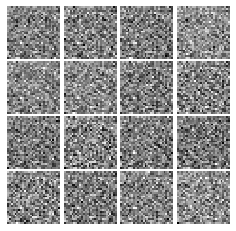


Iter: 250, D: 0.1484, G:0.5455


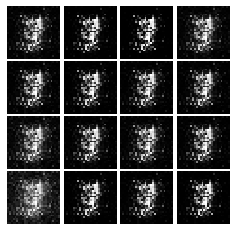

KeyboardInterrupt: 

In [89]:
# LSGAN
D_LS = discriminator().to(device)
G_LS = generator().to(device)

D_LS_optimizer = torch.optim.Adam(D_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))
G_LS_optimizer = torch.optim.Adam(G_LS.parameters(), lr=1e-3, betas = (0.5, 0.999))

train(D_LS, G_LS, D_LS_optimizer, G_LS_optimizer, ls_discriminator_loss, ls_generator_loss, train_loader=loader_train, num_epochs=10, device=device)